In [1]:
import os, sys
import numpy as np

from pathlib import Path

from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack, join

from scipy import interpolate
import scipy.stats as stats
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

sys.path.append("./py")
from utils import *

sys.path.append("/Users/aberti/Desktop/research")
from plotutils import get_corners, fig_labels, get_colors, plot_settings
plt.rcParams.update(**plot_settings)

plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"

from params import BASEDIR, DATADIR, SIMDIR, H0, Om0
from params import get_boxsize, get_zsnap_data, get_sham_var_bins, get_abs_mag_lim, get_abs_mag_bins_clust

#-- bins for clustering (data and mocks)
from params import H0, bin_file_comoving#, bin_file

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

import Corrfunc
from Corrfunc.theory.wp import wp as wp_corrfunc


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:550: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-9.00 or later is installed on your system
  % gs_req)


<a class="anchor" id="outline"></a>

* [Load mock catalog](#load_mock)
* [Color scatter plateau test](#plateau)
* [Clustering](#clustering)
 * [Full mock combined figures](#clust_full_combined)



# Set parameters


In [2]:
band   = "MW1"
zrange = (0.4,0.5)

zmag_lim = 20.7
sim_tag  = "mdpl2"
sham_tag = "vpeak"
d        = "south"
pimax    = 150
h        = H0/100.
print(f"h = {h}")

boxsize = get_boxsize(sim_tag)

#========== BEGIN HOUSEKEEPING ==========#
z_snaps, snap_nums, snaps = get_zsnap_data(sim_tag)

hist_idx = [len(snaps)-i for i in snap_nums]
vol_sim  = get_boxsize(sim_tag)**3
a_snaps  = [snaps["scale"][snaps["snapnum"]==sn].data[0] for sn in snap_nums]

sham_var_bins, sham_var_cens = get_sham_var_bins(sham_tag)

zmin, zmax  = zrange
cat_tag     = get_cat_tag(d,zrange)
abs_mag_lim = get_abs_mag_lim(zmin, band)
zsim        = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
zsnap_tag   = get_zsnap_tag(zsim)
zmag_tag    = get_zmag_tag(zmag_lim)

MW1lim = get_abs_mag_lim(zmin,"MW1")
Mrlim  = get_abs_mag_lim(zmin,"Mr")
Mzlim  = get_abs_mag_lim(zmin,"Mz")
if band=="MW1":
    abs_mag_lim_tag = get_MW1_tag(MW1lim)
elif band=="Mr":
    abs_mag_lim_tag = get_Mr_tag(Mrlim)
elif band=="Mz":
    abs_mag_lim_tag = get_Mz_tag(Mzlim)
else:
    raise Exception()

n_mag_bins_clust   = 4
abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=n_mag_bins_clust)
abs_mag_bin_tags   = get_abs_mag_bin_tags(zmin, band, nbins=n_mag_bins_clust)

lf_name  = f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_{abs_mag_lim_tag}.npy"
lum_func_full = np.load(f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_full.npy").item()

abs_mag_bins = np.round(lum_func_full["abs_mag_bins"],2)
#=========== END HOUSEKEEPING ===========#

print(band)
print(zrange)

params = dict(band=band,
              zrange=zrange, zmin=zmin, zmax=zmax,
              zmag_lim=zmag_lim,
              sim_tag=sim_tag,
              sham_tag=sham_tag,
              d=d,
              pimax=pimax,
              h=h,
              z_snaps=z_snaps,
              snap_nums=snap_nums,
              a_snaps=a_snaps,
              snaps=snaps,
              hist_idx=hist_idx,
              vol_sim=vol_sim,
              sham_var_bins=sham_var_bins,
              sham_var_cens=np.round(sham_var_cens,3),
              cat_tag=cat_tag,
              abs_mag_lim=abs_mag_lim,
              zsim=zsim,
              zsnap_tag=zsnap_tag,
              zmag_tag=zmag_tag,
              Mzlim=Mzlim,
              MW1lim=MW1lim,
              abs_mag_lim_tag=abs_mag_lim_tag,
              n_mag_bins_clust=n_mag_bins_clust,
              abs_mag_bins_clust=abs_mag_bins_clust,
              abs_mag_bin_tags=abs_mag_bin_tags,
              lum_func_full=lum_func_full,
             )

def param_list(values=False):
    for k in params.keys():
        ktype = str(type(params[k]))[8:-2]
        if values:
            if ktype in ("str","float","int","numpy.float64","numpy.ndarray","list","tuple","bool"):
                print(f"{k} ({ktype})\n{params[k]}\n")
            elif ktype=="dict":
                print(f"{k} ({ktype})\n{list(params[k].keys())}\n")
            elif "table" in ktype:
                print(f"{k} (table)\n{params[k].colnames}\n")
            else:
                print(f"{k} ({ktype})\n")
        else:
            print(f"{k}")



h = 0.6777
MW1
(0.4, 0.5)


<a class="anchor" id="load_mock"></a>

# Load mock

[BACK TO TOP](#outline)


In [14]:
%%time

# f = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{abs_mag_lim_tag}"
f = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/color_scatter/{zsnap_tag}_{abs_mag_lim_tag}"

# galcat_fname = f"{f}_galcat-hist-LRG.npy"
galcat_fname = f"{f}_galcat-LRG.npy"

print(galcat_fname)

galcat = Table(np.load(galcat_fname))


/Users/aberti/Desktop/research/desi_lrg_sham/mocks/mdpl2/vpeak/south/color_scatter/zsnap0p42531_MW1limn22p25_galcat-LRG.npy
CPU times: user 10.1 s, sys: 2.22 s, total: 12.3 s
Wall time: 12.9 s


In [15]:
galcat.sort("vpeak")

is_LRG_opt = galcat["LRG_opt_csrand"]
is_LRG_IR  = galcat["LRG_IR_csrand"]

N_LRG_opt = len(galcat[is_LRG_opt])
N_LRG_IR  = len(galcat[is_LRG_IR])

LRG_opt_vpeak = galcat[-N_LRG_opt:]
LRG_IR_vpeak  = galcat[-N_LRG_IR:]


<a class="anchor" id="clustering"></a>

# Clustering

[BACK TO TOP](#outline)


In [4]:
popt = {"MW1":{0.4:(-22.3, -439.2),
               0.5:(21.3, 584.0),
               0.6:(31.2, 839.4),
              },
        "Mz": {0.4:(-11.4, -181.5),
               0.5:(60.9, 1435.6),
               0.6:(50.8, 1248.4),
              },
       }

(m_los, b_los) = popt[band][zmin]

print(m_los, b_los)

model_mags = galcat[band].data
m_los, b_los = popt[band][zmin]

sigma_los = m_los*model_mags + b_los
sigma_los[sigma_los < 0] = 0

n_iter   = 1
nthreads = 2
DS       = 1
cross    = "GXG"


-22.3 -439.2


## Mock LRG color scatter test
(LRG clustering without color scatter in **figures** notebook)

In [ ]:
from scipy.signal import savgol_filter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

def _plot(selection, galcat=None, zmin=None, band=None, n_iter=1, nthreads=2, rp_use_range=(0.1,None), save=False,
          color_sigs=None):
    
    if None not in color_sigs:
        color_sigs = np.concatenate([[None],color_sigs])

    c_opt, c_IR = get_colors(2)

    lrg_mask_opt = galcat["LRG_opt"]==True
    lrg_mask_IR  = galcat["LRG_IR"]==True
    
    #-- compute sigma_los for specified parameterization
    m_los, b_los = popt[band][zmin]
    sigma_los = m_los*galcat[band].data + b_los
    sigma_los[sigma_los <= 0.0] = 0.0
    
    if selection=="IR":
        print(f"{band}\tIR LRG selection\t{m_los,b_los}")
    elif (("opt" in selection) | (selection=="optical")):
        selection = "opt"
        print(f"{band}\toptical LRG selection\t{m_los,b_los}")
    else:
        raise Exception()

    
    fig, ax = plt.subplots(1, 1, figsize=(6.5,6))

    ax.set_xlim(0.03,40)
    ax.set_ylim(30,250)
    ax.tick_params(axis="both", which="major", labelsize=24)
    
    ax.yaxis.set_major_locator(MultipleLocator(50))
    #ax.xaxis.set_major_formatter('{x:.0f}')
    ax.yaxis.set_minor_locator(MultipleLocator(10))

    #-- DATA clustering measurements
    cross_data = "LXL" if selection=="IR" else "LXLopt"
    fpath    = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/no_abs_mag_bins"
    wp_fname = f"{fpath}/wp/{cat_tag}_{cross_data}_pimax{int(pimax)}.txt"
    assert(os.path.exists(wp_fname))
    data   = ascii.read(wp_fname)
    #-- units of rp used for data clustering measurements are Mpc (not comoving)
    #-- multiply by h to convert to comoving Mpc and compare to model
    rp_cen = h*data["rp_cen"]
    #-- wp has same units as rp, so multiply by h as well (same for wp error)
    wp_dat = h*data["wp"]
    wp_err = h*np.sqrt(data["wp_err"])

    zphot_label = f"$({zmin}$" + r"$<z_{\rm phot}<\ $" + f"${zmax})$"
    data_label  = "IR LRGs" if selection=="IR" else "optical LRGs"
    data_label  = data_label + " " + zphot_label
    zsim_label  = r"$z_{\rm sim}=$" + f"${zsim:.3f}$"

    ax.errorbar(rp_cen, rp_cen*wp_dat, yerr=rp_cen*wp_err, label=data_label, color="black", marker="o", ms=5, ls="", ecolor="black", alpha=0.8)

    ax.set_xlabel(fig_labels["rp"], fontsize=28)
    ax.set_ylabel(fig_labels["rpwp"], fontsize=28)
    
    #-- MODEL clustering measurements
    #-- rp bins used to measure model clustering already have units of comoving Mpc, so do NOT multiply by h
    b = ascii.read(bin_file_comoving)
    rp_bins = np.concatenate([b["col1"],[b["col2"][-1]]])
    rp_mids = 0.5*(rp_bins[1:] + rp_bins[:-1])

    one_halo = (rp_cen > 0.1) & (rp_cen < 1.0)
    two_halo = (rp_cen > 1.0)

    wp_mod_no_scatter = None
    for cs in color_sigs:
        if cs is not None:
            if (selection=="IR"):
                lrg_mask = galcat[f"LRG_IR_cs{str(cs).replace('.','p')}"]==True
            elif (selection=="opt"):
                lrg_mask = galcat[f"LRG_opt_cs{str(cs).replace('.','p')}"]==True
            else:
                raise Exception()
        else:
            lrg_mask = lrg_mask_opt if (selection=="opt") else lrg_mask_IR
        out = []
        for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
            xx = galcat[u][lrg_mask]
            yy = galcat[v][lrg_mask]
            zz = galcat[w][lrg_mask]
            z_scatter = np.array([np.random.normal(zz, sigma_los[lrg_mask], len(zz)) for idx in range(n_iter)])
            z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
            z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

            out.append([wp_corrfunc(boxsize, pimax, nthreads, bin_file_comoving, xx, yy, z_s, output_rpavg=False)["wp"] for z_s in z_scatter])

        out = np.concatenate(out).T

        wp_mean = np.mean(out, axis=1)
        wp_mod  = wp_mean

        N_lrg_opt = len(galcat[lrg_mask_opt])
        N_lrg_IR  = len(galcat[lrg_mask_IR])
                  
        labels = {"opt":r"${\rm mock\ optical\ LRGs}$" + f" $(N={N_lrg_opt})$",
                  "IR":r"${\rm mock\ IR\ LRGs}$" + f" $(N={N_lrg_IR})$",
                 }

        if (cs==None):
            wp_mod_no_scatter = wp_mod
            diff = wp_mod_no_scatter/wp_dat - 1
            pct_diff_str = f"({np.mean((diff)[one_halo]):.2f}, {np.mean((diff)[two_halo]):.2f})"
            print( f"None\t{pct_diff_str}" )
            if len(color_sigs)==1:
                ax.plot(rp_cen, savgol_filter(rp_cen*wp_mod,7,3), color=color, label=labels[selection] + f";\nno color scatter {pct_diff_str}", lw=2)
            else:
                ax.plot(rp_cen, savgol_filter(rp_cen*wp_mod,7,3), color="gray", label=labels[selection] + f";\nno color scatter {pct_diff_str}", lw=2, ls="--")
        else:
            diff = wp_mod/wp_dat - 1 
            pct_diff_str = f"({np.mean((diff)[one_halo]):.2f}, {np.mean((diff)[two_halo]):.2f})"
            print( f"{cs}\t{pct_diff_str}" )
            ax.plot(rp_cen, savgol_filter(rp_cen*wp_mod,7,3), label=f"with color scatter {cs} {pct_diff_str}", lw=2)#, color=color)

    ax.legend(numpoints=2, handlelength=2, fontsize=16, loc=2, handletextpad=0.2, labelspacing=0.25)
    ax.semilogx()
    
    ax.text(*get_corners(ax, logx=True, margin=0.05)["lower_left"], zsim_label, fontsize=24, va="bottom", ha="left")

    rp_use_min, rp_use_max = rp_use_range
    if rp_use_min != None:
        ax.fill_between((ax.get_xlim()[0],rp_use_min), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)
    if rp_use_max != None:
        ax.fill_between((rp_use_max,ax.get_xlim()[-1]), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)
    plt.tight_layout()
    
    figname = f"{BASEDIR}/figures/wp_data-vs-mock/color_scatter/wp_{cat_tag[:-6]}_{abs_mag_lim_tag}_LRG-{selection}.png"

    print(figname)
    if save:
        plt.savefig(figname, dpi=200, bbox_inches="tight", pad_inches=0.1)
    plt.show()
    


In [ ]:
%%time

kwargs = dict(galcat=galcat, zmin=zmin, band=band, color_sigs=color_sig_array, save=True)

selection = "opt"
_plot(selection, **kwargs)

selection = "IR"
_plot(selection, **kwargs)


<a class="anchor" id="plateau"></a>

# Color scatter plateau test

[BACK TO TOP](#outline)


In [ ]:
def cs_test(selection, galcat=None, zmin=None, band=None, n_iter=1, nthreads=2, color_sigs=None):
    results = []
    
    if None not in color_sigs:
        color_sigs = np.concatenate([[None],color_sigs])

    lrg_mask_opt = galcat["LRG_opt"]==True
    lrg_mask_IR  = galcat["LRG_IR"]==True
    
    #-- compute sigma_los for specified parameterization
    m_los, b_los = popt[band][zmin]
    sigma_los = m_los*galcat[band].data + b_los
    sigma_los[sigma_los <= 0.0] = 0.0
    
    if selection=="IR":
        print(f"{band}\tIR LRG selection\t{m_los,b_los}")
    elif (("opt" in selection) | (selection=="optical")):
        selection = "opt"
        print(f"{band}\toptical LRG selection\t{m_los,b_los}")
    else:
        raise Exception()

    #-- DATA clustering measurements
    cross_data = "LXL" if selection=="IR" else "LXLopt"
    fpath    = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/no_abs_mag_bins"
    wp_fname = f"{fpath}/wp/{cat_tag}_{cross_data}_pimax{int(pimax)}.txt"
    assert(os.path.exists(wp_fname))
    data   = ascii.read(wp_fname)
    #-- units of rp used for data clustering measurements are Mpc (not comoving)
    #-- multiply by h to convert to comoving Mpc and compare to model
    rp_cen = h*data["rp_cen"]
    #-- wp has same units as rp, so multiply by h as well (same for wp error)
    wp_dat = h*data["wp"]
    wp_err = h*np.sqrt(data["wp_err"])
    
    #-- MODEL clustering measurements
    #-- rp bins used to measure model clustering already have units of comoving Mpc, so do NOT multiply by h
    b = ascii.read(bin_file_comoving)
    rp_bins = np.concatenate([b["col1"],[b["col2"][-1]]])
    rp_mids = 0.5*(rp_bins[1:] + rp_bins[:-1])

    one_halo = (rp_cen > 0.1) & (rp_cen < 1.0)
    two_halo = (rp_cen > 1.0)

    wp_mod_no_scatter = None
    for cs in color_sigs:
        if cs is not None:
            if (selection=="IR"):
                lrg_mask = galcat[f"LRG_IR_cs{str(cs).replace('.','p')}"]==True
            elif (selection=="opt"):
                lrg_mask = galcat[f"LRG_opt_cs{str(cs).replace('.','p')}"]==True
            else:
                raise Exception()
        else:
            lrg_mask = lrg_mask_opt if (selection=="opt") else lrg_mask_IR
        out = []
        for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
            xx = galcat[u][lrg_mask]
            yy = galcat[v][lrg_mask]
            zz = galcat[w][lrg_mask]
            z_scatter = np.array([np.random.normal(zz, sigma_los[lrg_mask], len(zz)) for idx in range(n_iter)])
            z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
            z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

            out.append([wp_corrfunc(boxsize, pimax, nthreads, bin_file_comoving, xx, yy, z_s, output_rpavg=False)["wp"] for z_s in z_scatter])

        out = np.concatenate(out).T

        wp_mean = np.mean(out, axis=1)
        wp_mod  = wp_mean

        if (cs==None):
            wp_mod_no_scatter = wp_mod
            diff = wp_mod_no_scatter/wp_dat - 1
            pct_diff_str = f"({np.mean((diff)[one_halo]):.2f}, {np.mean((diff)[two_halo]):.2f})"
            print( f"None\t{pct_diff_str}" )
            row = [0.0, np.round(np.mean((diff)[one_halo]),2), np.round(np.mean((diff)[two_halo]),2) ]
        else:
            diff = wp_mod/wp_dat - 1 
            pct_diff_str = f"({np.mean((diff)[one_halo]):.2f}, {np.mean((diff)[two_halo]):.2f})"
            print( f"{cs}\t{pct_diff_str}" )
            row = [np.round(cs,2), np.round(np.mean((diff)[one_halo]),2), np.round(np.mean((diff)[two_halo]),2) ]
        
        results.append(row)

    return Table(data=np.array(results), names=("cs","1h","2h"))


In [ ]:
%%time

color_sig_array = (0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0)

kwargs = dict(galcat=galcat, zmin=zmin, band=band, color_sigs=color_sig_array)

diff_opt = cs_test("opt", **kwargs)

diff_ir  = cs_test("IR", **kwargs)


In [ ]:
c_opt, c_ir = get_colors(2)

fig, ax = plt.subplots(1, 1, figsize=(6,6))

if band=="Mz":
    ax.plot(diff_opt["cs"], diff_opt["1h"], color=c_opt, label="opt LRG 1-halo")
    ax.plot(diff_opt["cs"], diff_opt["2h"], color=c_opt, ls="--", label="opt LRG 2-halo")

ax.plot(diff_ir["cs"], diff_ir["1h"], color=c_ir, label="IR LRG 1-halo")
ax.plot(diff_ir["cs"], diff_ir["2h"], color=c_ir, ls="--", label="IR LRG 2-halo")

ax.legend()
ax.set_xlabel("color scatter sigma")
ax.set_ylabel("percent difference from data")
ax.set_xlim(-0.05,1.05)
ax.set_ylim(0, 0.45)

zsim_label = r"$z_{\rm sim}=$" + f"${zsim:.3f}$"
ax.text(*get_corners(ax)["lower_left"], f"${band[1:]}$-band model\n{zsim_label}")

plt.tight_layout()

figname = f"{BASEDIR}/figures/cs-plateau-test_{cat_tag[:-6]}_{band}.png"
print(figname)
plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

plt.show()


## Magnitude bins

MW1 0.4
MW1n30p0-n23p15	0.044	-0.133	266
MW1n23p15-n22p85	0.056	-0.282	410
MW1n22p85-n22p55	0.105	-0.313	1255
MW1n22p55-n22p25	0.133	-0.375	1601


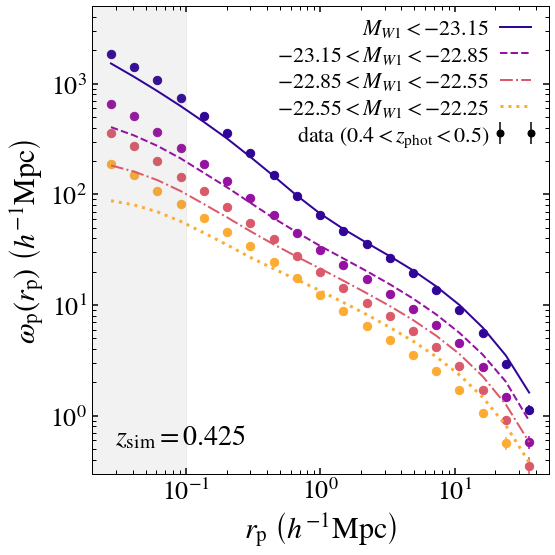

CPU times: user 1min 33s, sys: 2.06 s, total: 1min 35s
Wall time: 1min 32s


In [9]:
%%time

from scipy.signal import savgol_filter

save = False

rp_use_range = (0.1,None)
rp_use_min, rp_use_max = rp_use_range

colors     = get_colors(4)
linestyles = ("-","--","dashdot",":")
linewidths = (2, 2, 2, 3)

fig, ax = plt.subplots(1, 1, figsize=(8,8))

zphot_label = f"$({zmin}$" + r"$ < z_{\rm phot} < $" + f"${zmax})$"

print(band, zmin)
for i,abs_mag_bin_tag in enumerate(abs_mag_bin_tags):
    #-- DATA
    fpath    = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/{abs_mag_bin_tag}/wp"
    wp_fname = f"{cat_tag}_{cross}_pimax{int(pimax)}.txt"

    data   = ascii.read(f"{fpath}/{wp_fname}")
    rp_cen = h*data["rp_cen"].data
    wp_dat = h*data["wp"].data
    wp_err = h*np.sqrt(data["wp_err"].data)

    rp_pi_counts_fname = f"{fpath[:-3]}/rp_pi_counts/{cat_tag}_{cross}.npy"
    cov     = cov_from_rp_pi(rp_pi_counts_fname, cross=cross, rp_mids=rp_cen, pimax=pimax)
    cov_inv = np.linalg.inv(cov)

    #-- MODEL
    mag_min, mag_max = abs_mag_bins_clust[i:i+2]
    mag_mask = (model_mags > mag_min) & (model_mags <= mag_max)

    out = []
    for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
        xx = galcat[u]
        yy = galcat[v]
        zz = galcat[w]
        z_scatter = np.array([np.random.normal(zz, sigma_los, len(zz)) for idx in range(n_iter)])
        z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
        z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

        args = (boxsize, pimax, nthreads, bin_file_comoving, xx[mag_mask][::DS], yy[mag_mask][::DS])
        out.append([wp_corrfunc(*args, z_s[mag_mask][::DS], output_rpavg=False)["wp"] for z_s in z_scatter])

    out = np.concatenate(out).T

    wp_mod = np.mean(out, axis=1)

    rp_use_min, rp_use_max = rp_use_range
    if (rp_use_min != None) & (rp_use_max != None):
        rp_use_idx = np.where((rp_cen > rp_use_min) & (rp_cen < rp_use_max))[0]
    elif (rp_use_min != None) & (rp_use_max==None):
        rp_use_idx = np.where(rp_cen > rp_use_min)[0]
    elif (rp_use_min==None) & (rp_use_max != None):
        rp_use_idx = np.where(rp_cen < rp_use_max)[0]
    else:
        rp_use_idx = np.arange(len(rp_cen))

    chisq = np.sum([ [ (wp_dat - wp_mod)[i]*cov_inv[i,j]*(wp_dat - wp_mod)[j] for i in rp_use_idx ] for j in rp_use_idx ])

    label = get_abs_mag_bin_label(abs_mag_bin_tag)# + f" ($\chi^2 \sim {10*int(chisq/10)}$)"
    one_halo = (rp_cen > 0.1) & (rp_cen < 1.0)
    two_halo = (rp_cen > 1.0)
    pct_diff = 1 - wp_mod/wp_dat
    #print( f"{np.mean(pct_diff[one_halo]):.3f}\t{np.mean(pct_diff[two_halo]):.3f}" )
    print( f"{abs_mag_bin_tag}\t{np.mean(pct_diff[one_halo]):.3f}\t{np.mean(pct_diff[two_halo]):.3f}\t{int(chisq)}" )
    ax.scatter(rp_cen, 10**(np.log10(wp_dat)-0.15*i), color=colors[i], s=70)
    if i==0:
        ax.errorbar(rp_cen, np.zeros(len(rp_cen)), yerr=np.zeros(len(rp_cen)), label=f"data {zphot_label}", color="black", marker="o", ms=7, ls="", ecolor="black")
    ax.errorbar(rp_cen, 10**(np.log10(wp_dat)-0.15*i), yerr=wp_err, color=colors[i], ls="", label="")
    ax.plot(rp_cen, savgol_filter(10**(np.log10(wp_mod)-0.15*i),7,3), label=label, color=colors[i], ls=linestyles[i], lw=linewidths[i])

ax.loglog()
ax.set_xlim(0.02,50)
ax.set_ylim(0.3,5e3)

ax.tick_params(axis="both", which="major", labelsize=26)
ax.set_xlabel(fig_labels["rp"], fontsize=30)
ax.set_ylabel(fig_labels["wp"], fontsize=30)

ax.legend(loc=1, fontsize=22, labelspacing=0.2, handletextpad=0.2, borderpad=0.01, markerfirst=False, numpoints=2)

zsim_label = r"$z_{\rm sim} = $" + f"${np.round(zsim,3)}$"
ax.text(*get_corners(ax,log=True,margin=0.05)["lower_left"], zsim_label, ha="left", va="bottom", fontsize=28)

ax.fill_between((ax.get_xlim()[0],0.1),ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)

plt.tight_layout()

if save:
    figname = f"{BASEDIR}/figures/wp_data-vs-mock/mag-bins_{cat_tag[:-6]}_{band}.png"
    print(figname)
    plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

plt.show()


[RETURN TO LOAD MOCK](#load_mock)

## Full mock clustering

NameError: name 'pcf_diff_str' is not defined

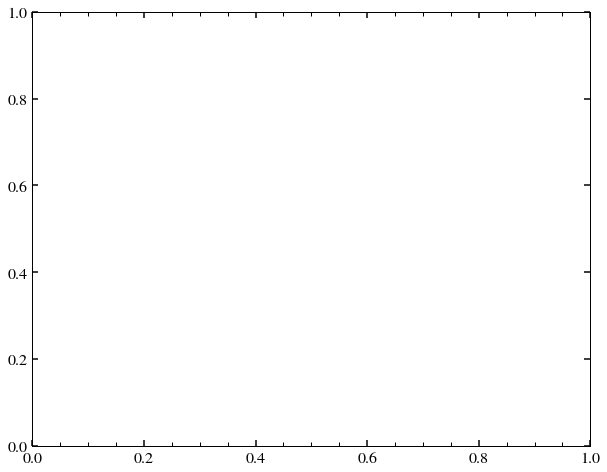

In [8]:
%%time

save = False

c_opt, c_IR = get_colors(2)
color = c_IR if band=="MW1" else c_opt

zphot_label = f"${zmin}$" + r"$ < z_{\rm phot} < $" + f"${zmax}$"
zsim_label  = r"$z_{\rm sim} = $" + f"${np.round(zsim,3)}$"

fig, ax = plt.subplots(1, 1, figsize=(10,8))

#-- DATA
fpath    = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/no_abs_mag_bins/wp"
wp_fname = f"{cat_tag}_{cross}_pimax{int(pimax)}.txt"

data   = ascii.read(f"{fpath}/{wp_fname}")
rp_cen = h*data["rp_cen"].data
wp_dat = h*data["wp"].data
wp_err = h*np.sqrt(data["wp_err"].data)

# rp_pi_counts_fname = f"{fpath[:-3]}/rp_pi_counts/{cat_tag}_{cross}.npy"
# print(rp_pi_counts_fname)
# cov     = cov_from_rp_pi(rp_pi_counts_fname, cross=cross, rp_mids=rp_cen, pimax=pimax)
# cov_inv = np.linalg.inv(cov)

#-- MODEL
out = []
for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
    xx = galcat[u]
    yy = galcat[v]
    zz = galcat[w]
    z_scatter = np.array([np.random.normal(zz, sigma_los, len(zz)) for idx in range(n_iter)])
    z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
    z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

    args = (boxsize, pimax, nthreads, bin_file_comoving, xx[::DS], yy[::DS])
    out.append([wp_corrfunc(*args, z_s[::DS], output_rpavg=False)["wp"] for z_s in z_scatter])
out = np.concatenate(out).T
wp_mod = np.mean(out, axis=1)

rp_use_min, rp_use_max = rp_use_range
if (rp_use_min != None) & (rp_use_max != None):
    rp_use_idx = np.where((rp_cen > rp_use_min) & (rp_cen < rp_use_max))[0]
elif (rp_use_min != None) & (rp_use_max==None):
    rp_use_idx = np.where(rp_cen > rp_use_min)[0]
elif (rp_use_min==None) & (rp_use_max != None):
    rp_use_idx = np.where(rp_cen < rp_use_max)[0]
else:
    rp_use_idx = np.arange(len(rp_cen))
    
# chisq = np.sum([ [ (wp_dat - wp_mod)[i]*cov_inv[i,j]*(wp_dat - wp_mod)[j] for i in rp_use_idx ] for j in rp_use_idx ])
# print( int(chisq) )

one_halo = (rp_cen > 0.1) & (rp_cen < 1.0)
two_halo = (rp_cen > 1.0)
pct_diff = wp_mod/wp_dat - 1
pct_diff_str = f"{np.mean(pct_diff[one_halo]):.2f}, {np.mean(pct_diff[two_halo]):.2f}"
print(pcf_diff_str)

if band=="MW1":
    abs_mag_lim_label = r"$(M_{W1}$" + f"$ < {abs_mag_lim})$"
elif band=="Mz":
    abs_mag_lim_label = f"$(M_z < {abs_mag_lim})$"
else:
    raise Exception()

label_data = "data " + abs_mag_lim_label# + "\n" + zphot_label
ax.errorbar(rp_cen, rp_cen*wp_dat, yerr=wp_err, color="k", ls="", marker=".", ms=15, label=label_data)
ax.plot(rp_cen, savgol_filter(rp_cen*wp_mod,7,3), label="model (" + pct_diff_str + ")", color=color, lw=2)

ax.semilogx()
ax.set_xlim(0.02,50)
ax.set_ylim(20,120)

ax.legend(loc=1, fontsize=24, numpoints=2, handletextpad=0.25)#, labelspacing=0.25)
ax.text(*get_corners(ax,logx=True)["upper_left"], zsim_label, ha="left", va="top", fontsize=24)

ax.fill_between((ax.get_xlim()[0],0.1),ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)

ax.set_xlabel(fig_labels["rp"], fontsize=30)
ax.set_ylabel(fig_labels["rpwp"], fontsize=30)

ax1 = ax.twinx()
ax1.errorbar(rp_cen, wp_dat, yerr=wp_err, color="gray", ls="", marker=".", ms=15)
ax1.semilogy(rp_cen, savgol_filter(wp_mod,7,3), color=color, lw=1.5, ls="--")
ax1.set_ylim(0.3,5e3)
ax1.set_ylabel(fig_labels["wp"], fontsize=30)

ax1.set_xscale("log")
ax1.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

for ax in (ax,ax1):
    ax.tick_params(axis="both", which="major", labelsize=26)

plt.tight_layout()

if save:
    figname = f"{BASEDIR}/figures/wp-compare_{cat_tag[:-6]}_{band}.png"
    print(figname)
    plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

plt.show()


<a class="anchor" id="clust_full_combined"></a>

## Full mock clustering COMBINED FIGURES

[BACK TO TOP](#outline)


In [ ]:
popt = {"MW1":{0.4:(-22.3, -439.2),
               0.5:(21.3, 584.0),
               0.6:(31.2, 839.4),
              },
        "Mz": {0.4:(-11.4, -181.5),
               0.5:(60.9, 1435.6),
               0.6:(50.8, 1248.4),
              },
       }

n_iter   = 1
nthreads = 2
cross    = "GXG"

wp_mod_dict = {}

for zm in (0.4,0.5,0.6):
    wp_mod_dict[zm] = {}


In [ ]:
# for this_zmin in (0.4,0.5,0.6):
#     for this_band in ("MW1","Mz"):
#         if this_band not in wp_mod_dict[this_zmin].keys():
#             this_abs_mag_lim = get_abs_mag_lim(this_zmin, this_band)
#             this_zsim        = np.array(z_snaps)[ np.round(z_snaps,1)==this_zmin ][0]
#             this_zsnap_tag   = get_zsnap_tag(this_zsim)

#             this_MW1lim = get_abs_mag_lim(this_zmin,"MW1")
#             this_Mzlim  = get_abs_mag_lim(this_zmin,"Mz")
#             if this_band=="MW1":
#                 this_abs_mag_lim_tag = get_MW1_tag(this_MW1lim)
#             elif band=="Mz":
#                 this_abs_mag_lim_tag = get_Mz_tag(this_Mzlim)
#             else:
#                 raise Exception()

#             f = f"{BASEDIR}/mocks/mdpl2/vpeak/south/{this_zsnap_tag}_{this_abs_mag_lim_tag}"

#             this_galcat_fname = f"{f}_galcat-hist-LRG.npy" #-- WITHOUT color scatter
#             # galcat_fname = f"{f}_galcat-LRG.npy" #-- WITH color scatter

#             print(f"Loading {this_galcat_fname}...")
#             this_galcat = Table(np.load(this_galcat_fname))

#             (m_los, b_los) = popt[this_band][this_zmin]

#             print(this_band, this_zmin, m_los, b_los)

#             these_model_mags = this_galcat[this_band].data

#             sigma_los = m_los*these_model_mags + b_los
#             sigma_los[sigma_los < 0] = 0

#             out = []
#             for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
#                 xx = this_galcat[u]
#                 yy = this_galcat[v]
#                 zz = this_galcat[w]
#                 z_scatter = np.array([np.random.normal(zz, sigma_los, len(zz)) for idx in range(n_iter)])
#                 z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
#                 z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

#                 args = (boxsize, pimax, nthreads, bin_file_comoving, xx, yy)
#                 out.append([wp_corrfunc(*args, z_s, output_rpavg=False)["wp"] for z_s in z_scatter])
#             out = np.concatenate(out).T
#             wp_mod = np.mean(out, axis=1)

#             wp_mod_dict[this_zmin][this_band] = wp_mod
            
# np.save(f"{BASEDIR}/data/wp_mod_dict.npy", wp_mod_dict, allow_pickle=True)


In [ ]:
%%time

from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

wp_mod_dict = np.load(f"{BASEDIR}/data/wp_mod_dict.npy", allow_pickle=True).item()

fig, axes = plt.subplots(2, 1, figsize=(6,10), sharex=True, sharey=True)

axes[-1].set_xlabel(fig_labels["rp"], fontsize=24)

for ax,this_band in zip(axes,("Mz","MW1")):
    ax.set_xlim(0.02,50)
    ax.set_ylim(0.3,5e3)
    ax.set_ylabel(fig_labels["wp"], fontsize=24)
    ax.tick_params(axis="both", which="major", labelsize=22)

    for i,this_zmin,color,ls,lw in zip((1,0,-1),(0.4,0.5,0.6),("gray","magenta","k"),("dashdot","--","-"),(2,2,1.5)):
        this_zmax   = this_zmin + 0.1
        this_zrange = (this_zmin, this_zmax)
        this_zsim = np.array(z_snaps)[ np.round(z_snaps,1)==this_zmin ][0]

        this_zphot_label = f"${this_zmin}$" + r"$ < z_{\rm phot} < $" + f"${this_zmax}$"
        this_zsim_label  = r"$z_{\rm sim} = $" + f"${np.round(this_zsim,3)}$"

        if this_band=="MW1":
            this_abs_mag_lim = get_abs_mag_lim(this_zmin,"MW1")
            this_abs_mag_lim_label = r"$(M_{W1}$" + f"$ < {this_abs_mag_lim})$"
            this_abs_mag_lim_tag = get_MW1_tag(this_abs_mag_lim)
            band_label = "$W1$-band (IR) model"
        elif this_band=="Mz":
            this_abs_mag_lim = get_abs_mag_lim(this_zmin,"Mz")
            this_abs_mag_lim_label = f"$(M_z < {this_abs_mag_lim})$"
            this_abs_mag_lim_tag = get_Mz_tag(this_abs_mag_lim)
            band_label = "$z$-band (optical) model"
        else:
            raise Exception()
 
        #-- DATA
        this_cat_tag = get_cat_tag("south",this_zrange)

        fpath    = f"{BASEDIR}/clustering/{zmag_tag}/{this_abs_mag_lim_tag}/no_abs_mag_bins/wp"
        wp_fname = f"{this_cat_tag}_{cross}_pimax{int(pimax)}.txt"

        data   = ascii.read(f"{fpath}/{wp_fname}")
        rp_cen = h*data["rp_cen"].data
        wp_dat = h*data["wp"].data
        wp_err = h*np.sqrt(data["wp_err"].data)

        #-- MODEL
        wp_mod = wp_mod_dict[this_zmin][this_band]

        one_halo = (rp_cen > 0.1) & (rp_cen < 1.0)
        two_halo = (rp_cen > 1.0)
        pct_diff = wp_mod/wp_dat - 1
        pct_diff_str = f"{np.mean(pct_diff[one_halo]):.2f}, {np.mean(pct_diff[two_halo]):.2f}"
        ax.errorbar(rp_cen, 10**(np.log10(wp_dat)-0.15*i), yerr=wp_err, color=color, ls="", marker=".", ms=10,
                    label=f"{this_zphot_label} {this_abs_mag_lim_label}")
        ax.loglog(rp_cen, 10**(np.log10(wp_mod)-0.15*i), color=color, lw=lw, ls=ls)

    ax.legend(loc=3, fontsize=17, numpoints=2, handletextpad=0.25, labelspacing=0.25, borderpad=0.01, handlelength=1.5)
    ax.text(*get_corners(ax,log=True)["upper_right"], band_label, ha="right", va="top", fontsize=20)

    ax.fill_between((ax.get_xlim()[0],0.1),ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)

handles = [Line2D([0], [0], color="gray", lw=2, ls="dashdot", label=r"$z_{\rm sim}=0.425$"),
           Line2D([0], [0], color="magenta", lw=2, ls="--", label=r"$z_{\rm sim}=0.523$"),
           Line2D([0], [0], color="k", lw=1.5, label=r"$z_{\rm sim}=0.628$"),]
ax1 = axes[0].twiny()
ax1.loglog()
ax1.set_xlim(0.02,50)
ax1.set_xticklabels([])
ax1.legend(handles=handles, fontsize=18, labelspacing=0.25, handletextpad=0.25, loc=(0.55,0.6))
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.025)

figname = f"{BASEDIR}/figures/wp-compare_full-samples.png"
print(figname)
# plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

plt.show()
